# SHO Fitter Reconstruction Results Visualization

In [1]:
import sys
sys.path.append('../../')

In [3]:
# import tools

import matplotlib.pyplot as plt
import numpy as np
import h5py
import time

import torch

from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error

from src.m3_learning.be.processing import convert_amp_phase
from src.m3_learning.util.preprocessing import global_scaler

## Loads Data

In [4]:
# Sets path to file
path = r"./"

# Opens the data file
h5_f = h5py.File(path + "data_file.h5", "r+")

# number of pixels in the image
num_pix = h5_f["Measurement_000"].attrs["num_pix"]

# Frequency Vector in Hz
frequency_bin = h5_f["Measurement_000"]["Channel_000"]["Bin_Frequencies"][:]

# number of DC voltage steps
voltage_steps = h5_f["Measurement_000"].attrs["num_udvs_steps"]

# Resampled frequency vector
wvec_freq = resample(frequency_bin, 80)

# get raw data (real and imaginary combined)
raw_data = h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]
raw_data_resampled = resample(np.array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]).reshape(-1, 165), 80, axis=1)

# conversion of raw data (both resampled and full)
amp, phase = convert_amp_phase(raw_data)
amp_resample, phase_resample = convert_amp_phase(raw_data_resampled)

scaled_data = h5_f["Measurement_000"]["Channel_000"]['complex']['scaled_data'][:]
real_resample = h5_f["Measurement_000"]["Channel_000"]['complex']['real_resample'][:]
imag_resample = h5_f["Measurement_000"]["Channel_000"]['complex']['imag_resample'][:]

# scale the real component of input data
scaler_real = global_scaler()
scaled_data_real = scaler_real.fit_transform(real_resample).reshape(-1, 80)

# scale the imaginary component of input data
scaler_imag = global_scaler()
scaled_data_imag = scaler_imag.fit_transform(imag_resample).reshape(-1, 80)

In [5]:
# TODO extract fit params

# create a list for parameters
fit_results_list = []
for sublist in np.array(
    h5_f["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Fit"]
):
    for item in sublist:
        for i in item:
            fit_results_list.append(i)

# flatten parameters list into numpy array
fit_results_list = np.array(fit_results_list).reshape(num_pix, voltage_steps, 5)

# exclude the R2 parameter
params = fit_results_list.reshape(-1, 5)[:, 0:4]

# scale the parameters (now takes only 4 parameters, excluding the R2)
params_scaler = StandardScaler()
scaled_params = params_scaler.fit_transform(fit_results_list.reshape(-1, 5)[:, 0:4])

In [6]:
data_train, data_test, params_train, params_test = train_test_split(
    scaled_data, scaled_params, test_size=0.7, random_state=42
)

params_test_unscaled = params_scaler.inverse_transform(params_test)

In [7]:
predictions = torch.tensor(h5_f['predictions'][:])

In [8]:
data_test_unscaled = data_test.copy()
predictions_unscaled = predictions.numpy().copy()

data_test_unscaled[:, :, 0] = scaler_real.inverse_transform(data_test_unscaled[:, :, 0])
data_test_unscaled[:, :, 1] = scaler_imag.inverse_transform(data_test_unscaled[:, :, 1])
data_test_unscaled = data_test_unscaled[:, :, 0] + 1j * data_test_unscaled[:, :, 1]

predictions_unscaled[:, :, 0] = scaler_real.inverse_transform(
    predictions_unscaled[:, :, 0]
)
predictions_unscaled[:, :, 1] = scaler_imag.inverse_transform(
    predictions_unscaled[:, :, 1]
)
predictions_unscaled = (
    predictions_unscaled[:, :, 0] + 1j * predictions_unscaled[:, :, 1]
)

## Visualizes Results

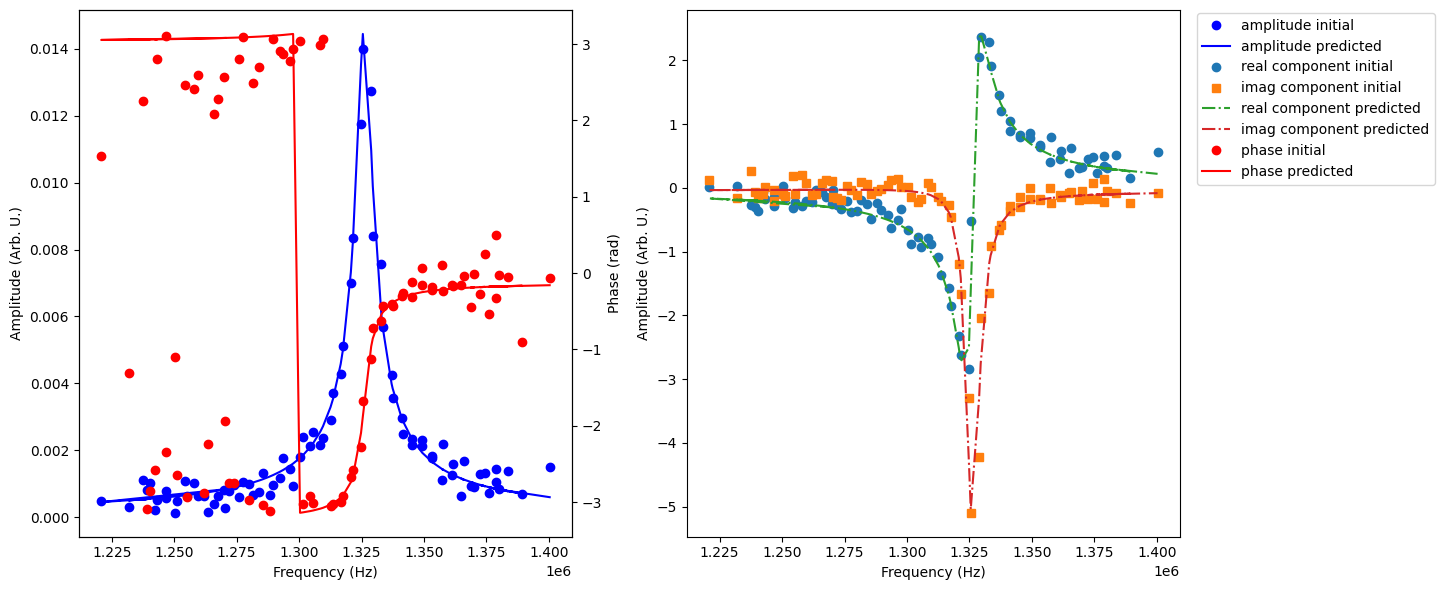

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

i = np.random.randint(0, predictions.shape[0])
magnitude_graph_test, phase_graph_test = convert_amp_phase(
    np.atleast_2d(data_test_unscaled[i, :])
)
magnitude_graph_pred, phase_graph_pred = convert_amp_phase(
    np.atleast_2d(predictions_unscaled[i, :])
)

axs[0].plot(
    wvec_freq, magnitude_graph_test[0, :], "o", label="amplitude initial", color="b"
)
axs[0].plot(
    wvec_freq, magnitude_graph_pred[0, :], label="amplitude predicted", color="b"
)
axs[0].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")
ax2 = axs[0].twinx()
ax2.plot(wvec_freq, phase_graph_test[0, :], "o", label="phase initial", color="r")
ax2.plot(wvec_freq, phase_graph_pred[0, :], label="phase predicted", color="r")
ax2.set(xlabel="Frequency (Hz)", ylabel="Phase (rad)")

axs[1].plot(wvec_freq, data_test[i][:, 0], "o", label="real component initial")
axs[1].plot(wvec_freq, data_test[i][:, 1], "s", label="imag component initial")
axs[1].plot(
    wvec_freq,
    predictions[i].cpu().detach().numpy()[:, 0],
    "-.",
    label="real component predicted",
)
axs[1].plot(
    wvec_freq,
    predictions[i].cpu().detach().numpy()[:, 1],
    "-.",
    label="imag component predicted",
)
axs[1].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")

fig.tight_layout()
fig.legend(bbox_to_anchor=(1.2, 0.97), loc="upper right", borderaxespad=0.0)

### Visualize Best/Worst Results

In [10]:
mse_real = mean_squared_error(
    data_test[:, :, 0], predictions[:, :, 0].cpu().detach().numpy()
)
mse_imag = mean_squared_error(
    data_test[:, :, 1], predictions[:, :, 1].cpu().detach().numpy()
)
print("MSE for real component: " + str(mse_real))
print("MSE for imaginary component: " + str(mse_imag))

error = (mse_real + mse_imag) / 2.0
print("Average MSE: " + str(error))

errors = np.sum(
    np.mean(np.square(data_test - predictions.cpu().detach().numpy()), 1), 1
)
errors = np.asarray(errors)
print(errors.shape)

MSE for real component: 0.043902498
MSE for imaginary component: 0.041627854
Average MSE: 0.04276517778635025
(967680,)


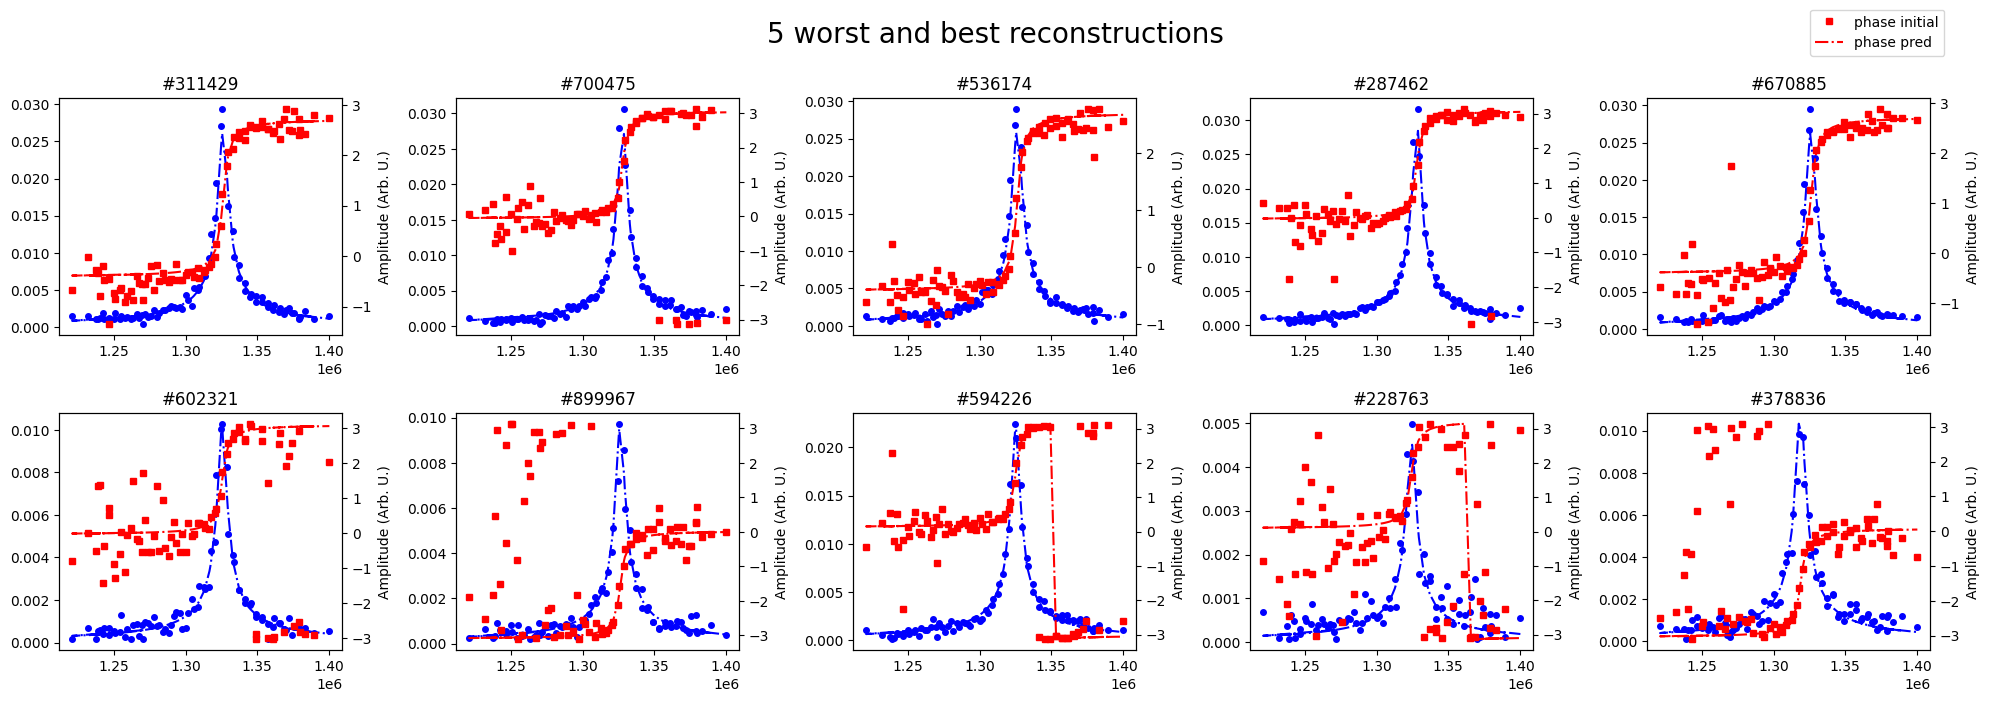

In [11]:
# sorting by highest and lowest MSE
highest = (-errors).argsort()[:5]

fig, axs = plt.subplots(2, 5, figsize=(20, 7))
fig.suptitle('5 worst and best reconstructions', fontsize=20)

i = 0
for x in highest:
    magnitude_graph_real, phase_graph_real = convert_amp_phase(np.atleast_2d(data_test_unscaled[x, :]))
    magnitude_graph_pred, phase_graph_pred = convert_amp_phase(np.atleast_2d(predictions_unscaled[x, :]))

    axs[0, i].plot(wvec_freq, magnitude_graph_real[0, :], 'o', markersize=4,
                    label='amplitude initial', color='b')
    axs[0, i].plot(wvec_freq, magnitude_graph_pred[0, :], '-.', label='amplitude pred', color='b')
    ax1 = axs[0, i].twinx()
    ax1.plot(wvec_freq, phase_graph_real[0, :], 's', markersize=4,
                    label='phase initial', color='r')
    ax1.plot(wvec_freq, phase_graph_pred[0, :], '-.', label='phase pred', color='r')
    ax1.set_title("#" + str(x))
    ax1.set(xlabel='Frequency (Hz)', ylabel='Amplitude (Arb. U.)')
    i += 1

for i in range(5):
    x = np.random.randint(0, data_test_unscaled.shape[0])
    magnitude_graph_real, phase_graph_real = convert_amp_phase(np.atleast_2d(data_test_unscaled[x, :]))
    magnitude_graph_pred, phase_graph_pred = convert_amp_phase(np.atleast_2d(predictions_unscaled[x, :]))

    axs[1, i].plot(wvec_freq, magnitude_graph_real[0, :], 'o', markersize=4,
                    label='amplitude initial', color='b')
    axs[1, i].plot(wvec_freq, magnitude_graph_pred[0, :], '-.', label='amplitude pred', color='b')
    ax2 = axs[1, i].twinx()
    ax2.plot(wvec_freq, phase_graph_real[0, :], 's', markersize=4,
                    label='phase initial', color='r')
    ax2.plot(wvec_freq, phase_graph_pred[0, :], '-.', label='phase pred', color='r')
    ax2.set_title("#" + str(x))
    ax2.set(xlabel='Frequency (Hz)', ylabel='Amplitude (Arb. U.)')
    i += 1

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 2.7), loc='upper right', borderaxespad=0.)
fig.subplots_adjust(top=0.87)

plt.savefig('Assets/Figures/best_and_worst_5_min_SHO_reconstructions.png', bbox_inches='tight')
plt.savefig('Assets/Figures/best_and_worst_5_min_SHO_reconstructions.svg', bbox_inches='tight')

In [12]:
h5_f.close()